# XGBoost Model - Random Train/Test Split

This notebook mirrors the XGBoost analysis in `4_Preprocessing_XGBoost_Model.ipynb`, 
but uses a **random 80/20 split** instead of the temporal split (2018-2023 train / 2024 test).

### Why compare?
- **Temporal split** tests whether the model generalizes to a future year (real-world scenario)
- **Random split** tests whether the model can learn the overall pattern regardless of year
- If random split performs much better, it suggests **distribution shift** between years

In [1]:
!pip install xgboost imbalanced-learn -q

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Combine All Years (2018-2024)

In [3]:
# Load both files and combine into one dataset
df_temporal_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_temporal_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

# Ensure same columns
common_cols = [c for c in df_temporal_train.columns if c in df_temporal_test.columns]
df_all = pd.concat([df_temporal_train[common_cols], df_temporal_test[common_cols]], ignore_index=True)

print(f"Temporal train: {df_temporal_train.shape}")
print(f"Temporal test:  {df_temporal_test.shape}")
print(f"Combined:       {df_all.shape}")
print(f"\nYears in combined data: {sorted(df_all['year'].unique())}")
print(f"\nYear distribution:")
print(df_all['year'].value_counts().sort_index())

Temporal train: (1469769, 27)
Temporal test:  (304368, 27)
Combined:       (1774137, 27)

Years in combined data: [np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

Year distribution:
year
2018    285102
2019    288761
2021    295421
2022    298668
2023    301817
2024    304368
Name: count, dtype: int64


## 2. Preprocessing

In [4]:
def preprocess_for_xgboost(df, label_encoders=None, fit=True):
    """
    Preprocessing pipeline for XGBoost.
    Null value handling based on ACS PUMS documentation.
    """
    df = df.copy()
    
    # Fill nulls based on ACS documentation
    df['ENG'] = df['ENG'].fillna(0)       # 0 = speaks only English
    df['LANP'] = df['LANP'].fillna(9999)  # 9999 = Other/unspecified
    df['WKHP'] = df['WKHP'].fillna(0)     # 0 = did not work
    df['WRK'] = df['WRK'].fillna(0)       # 0 = N/A
    df['OCCP'] = df['OCCP'].fillna('NILF') # Not in Labor Force
    
    categorical_cols = [
        'PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK',
        'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
        'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year'
    ]
    
    if label_encoders is None:
        label_encoders = {}
    
    for col in categorical_cols:
        if col not in df.columns:
            continue
        df[col] = df[col].astype(str)
        if fit:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    return df, label_encoders

# Preprocess the full dataset BEFORE splitting (so encoder sees all values)
df_all_processed, encoders = preprocess_for_xgboost(df_all, fit=True)
print(f"Processed shape: {df_all_processed.shape}")

Processed shape: (1774137, 27)


## 3. Random 80/20 Split

In [5]:
# Define features and target
exclude_cols = ['POVPIP', 'poverty_risk_score']
feature_cols = [c for c in df_all_processed.columns if c not in exclude_cols]

X = df_all_processed[feature_cols]
y = df_all_processed['poverty_risk_score'].astype(int)

# Random 80/20 split with stratification to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")
print(f"\nTrain class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())

Train: (1419309, 25)
Test:  (354828, 25)

Train class distribution:
poverty_risk_score
0    1078831
1     188031
2      75623
3      76824
Name: count, dtype: int64

Test class distribution:
poverty_risk_score
0    269708
1     47008
2     18906
3     19206
Name: count, dtype: int64


## 4. Baseline: XGBoost with Sample Weights

In [6]:
# Compute sample weights (inverse frequency)
class_counts = y_train.value_counts().sort_index()
total = len(y_train)
n_classes = len(class_counts)
class_weights = {i: total / (n_classes * count) for i, count in class_counts.items()}
sample_weights = y_train.map(class_weights).values

print(f"Class weights: {class_weights}")

Class weights: {0: 0.32889975352951484, 1: 1.887067823922651, 2: 4.69205466590852, 3: 4.618703139643861}


In [7]:
# Baseline XGBoost
class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

print("Training baseline XGBoost...")
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred = model.predict(X_test)
print(f"\nBest iteration: {model.best_iteration}")
print("\n=== Baseline: Sample Weights ===")
print(classification_report(y_test, y_pred, target_names=class_names))

Training baseline XGBoost...
[0]	validation_0-mlogloss:1.33432
[50]	validation_0-mlogloss:0.97286
[100]	validation_0-mlogloss:0.96225
[150]	validation_0-mlogloss:0.95549
[200]	validation_0-mlogloss:0.95097
[250]	validation_0-mlogloss:0.94733
[300]	validation_0-mlogloss:0.94425
[350]	validation_0-mlogloss:0.94207
[400]	validation_0-mlogloss:0.94000
[450]	validation_0-mlogloss:0.93831
[499]	validation_0-mlogloss:0.93659

Best iteration: 498

=== Baseline: Sample Weights ===
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.70      0.80    269708
Near Poverty (1)       0.27      0.42      0.33     47008
     Poverty (2)       0.19      0.40      0.26     18906
Deep Poverty (3)       0.28      0.58      0.38     19206

        accuracy                           0.64    354828
       macro avg       0.42      0.52      0.44    354828
    weighted avg       0.77      0.64      0.68    354828



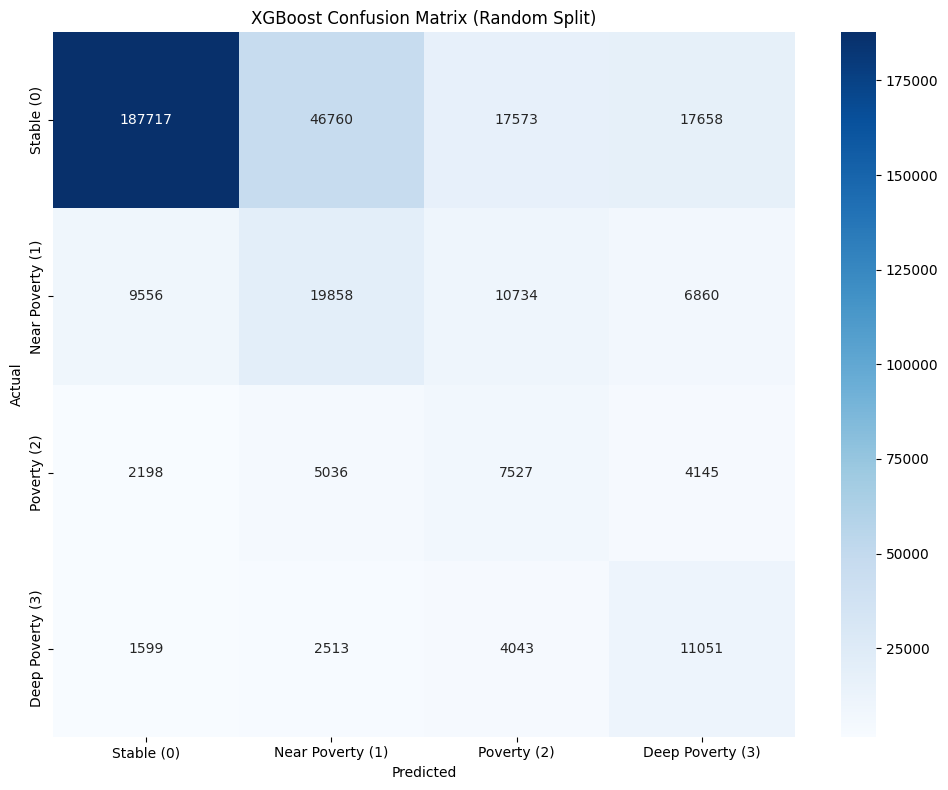

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix (Random Split)')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_random_split_confusion.png', dpi=150)
plt.show()

## 5. All 6 Class Imbalance Strategies

### Strategy 1: Random Undersampling

In [9]:
# Strategy 1: Undersample majority class
minority_total = y_train[y_train > 0].shape[0]

undersample_strategy = {
    0: minority_total,
    1: Counter(y_train)[1],
    2: Counter(y_train)[2],
    3: Counter(y_train)[3]
}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print(f"After undersampling: {Counter(y_train_under)}")

model_under = xgb.XGBClassifier(
    objective='multi:softmax', num_class=4, eval_metric='mlogloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)
model_under.fit(X_train_under, y_train_under, eval_set=[(X_test, y_test)], verbose=50)

y_pred_under = model_under.predict(X_test)
print(f"\nBest iteration: {model_under.best_iteration}")
print("\n=== Strategy 1: Undersampling ===")
print(classification_report(y_test, y_pred_under, target_names=class_names))

After undersampling: Counter({0: 340478, 1: 188031, 3: 76824, 2: 75623})
[0]	validation_0-mlogloss:1.16199
[50]	validation_0-mlogloss:0.71110
[100]	validation_0-mlogloss:0.69953
[150]	validation_0-mlogloss:0.69577
[200]	validation_0-mlogloss:0.69338
[250]	validation_0-mlogloss:0.69163
[300]	validation_0-mlogloss:0.69038
[350]	validation_0-mlogloss:0.68941
[400]	validation_0-mlogloss:0.68860
[450]	validation_0-mlogloss:0.68804
[499]	validation_0-mlogloss:0.68751

Best iteration: 499

=== Strategy 1: Undersampling ===
                  precision    recall  f1-score   support

      Stable (0)       0.90      0.82      0.86    269708
Near Poverty (1)       0.31      0.53      0.39     47008
     Poverty (2)       0.33      0.09      0.14     18906
Deep Poverty (3)       0.39      0.44      0.42     19206

        accuracy                           0.73    354828
       macro avg       0.48      0.47      0.45    354828
    weighted avg       0.76      0.73      0.73    354828



### Strategy 2: Pure SMOTE

In [10]:
# Strategy 2: Pure SMOTE - oversample minorities to 500k each
smote_target = 500000

rus_pre = RandomUnderSampler(
    sampling_strategy={0: smote_target, 1: Counter(y_train)[1], 2: Counter(y_train)[2], 3: Counter(y_train)[3]},
    random_state=42
)
X_pre, y_pre = rus_pre.fit_resample(X_train, y_train)

smote_pure = SMOTE(
    sampling_strategy={1: smote_target, 2: smote_target, 3: smote_target},
    random_state=42, k_neighbors=5
)
X_train_smote_pure, y_train_smote_pure = smote_pure.fit_resample(X_pre, y_pre)
print(f"After pure SMOTE: {Counter(y_train_smote_pure)}")

model_smote_pure = xgb.XGBClassifier(
    objective='multi:softmax', num_class=4, eval_metric='mlogloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)
model_smote_pure.fit(X_train_smote_pure, y_train_smote_pure, eval_set=[(X_test, y_test)], verbose=50)

y_pred_smote_pure = model_smote_pure.predict(X_test)
print(f"\nBest iteration: {model_smote_pure.best_iteration}")
print("\n=== Strategy 2: Pure SMOTE ===")
print(classification_report(y_test, y_pred_smote_pure, target_names=class_names))

After pure SMOTE: Counter({0: 500000, 1: 500000, 2: 500000, 3: 500000})
[0]	validation_0-mlogloss:1.32480
[50]	validation_0-mlogloss:0.83675
[100]	validation_0-mlogloss:0.78376
[150]	validation_0-mlogloss:0.75944
[200]	validation_0-mlogloss:0.74593
[250]	validation_0-mlogloss:0.73734
[300]	validation_0-mlogloss:0.73110
[350]	validation_0-mlogloss:0.72626
[400]	validation_0-mlogloss:0.72239
[450]	validation_0-mlogloss:0.71941
[499]	validation_0-mlogloss:0.71660

Best iteration: 499

=== Strategy 2: Pure SMOTE ===
                  precision    recall  f1-score   support

      Stable (0)       0.89      0.83      0.86    269708
Near Poverty (1)       0.32      0.38      0.35     47008
     Poverty (2)       0.24      0.19      0.21     18906
Deep Poverty (3)       0.33      0.50      0.40     19206

        accuracy                           0.72    354828
       macro avg       0.44      0.48      0.45    354828
    weighted avg       0.75      0.72      0.73    354828



### Strategy 3: Combined Resampling (SMOTE + Undersampling)

In [11]:
# Strategy 3: Combined - undersample majority THEN SMOTE oversample minorities
target_count = 200000

rus_step1 = RandomUnderSampler(
    sampling_strategy={0: target_count, 1: Counter(y_train)[1], 2: Counter(y_train)[2], 3: Counter(y_train)[3]},
    random_state=42
)
X_temp, y_temp = rus_step1.fit_resample(X_train, y_train)

smote = SMOTE(
    sampling_strategy={1: target_count, 2: target_count, 3: target_count},
    random_state=42, k_neighbors=5
)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)
print(f"After combined resampling: {Counter(y_train_smote)}")

model_smote = xgb.XGBClassifier(
    objective='multi:softmax', num_class=4, eval_metric='mlogloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)
model_smote.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)], verbose=50)

y_pred_smote = model_smote.predict(X_test)
print(f"\nBest iteration: {model_smote.best_iteration}")
print("\n=== Strategy 3: Combined Resampling ===")
print(classification_report(y_test, y_pred_smote, target_names=class_names))

After combined resampling: Counter({0: 200000, 1: 200000, 2: 200000, 3: 200000})
[0]	validation_0-mlogloss:1.33229
[50]	validation_0-mlogloss:0.92421
[100]	validation_0-mlogloss:0.89603
[150]	validation_0-mlogloss:0.87546
[200]	validation_0-mlogloss:0.86594
[250]	validation_0-mlogloss:0.85965
[300]	validation_0-mlogloss:0.85541
[350]	validation_0-mlogloss:0.85168
[400]	validation_0-mlogloss:0.84892
[450]	validation_0-mlogloss:0.84654
[499]	validation_0-mlogloss:0.84482

Best iteration: 499

=== Strategy 3: Combined Resampling ===
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.71      0.81    269708
Near Poverty (1)       0.27      0.58      0.37     47008
     Poverty (2)       0.22      0.18      0.20     18906
Deep Poverty (3)       0.32      0.52      0.39     19206

        accuracy                           0.66    354828
       macro avg       0.43      0.50      0.44    354828
    weighted avg       0.77      0.66      0.69    35482

### Strategy 4: Aggressive Class Weights

In [12]:
# Strategy 4: Aggressive class weights
aggressive_weights = {
    0: 0.25,
    1: 5.0,
    2: 15.0,
    3: 15.0
}
aggressive_sample_weights = y_train.map(aggressive_weights).values

print("Aggressive class weights:")
for cls, w in aggressive_weights.items():
    print(f"  Class {cls}: {w} (original: {class_weights[cls]:.2f})")

model_aggressive = xgb.XGBClassifier(
    objective='multi:softmax', num_class=4, eval_metric='mlogloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)

print("\nTraining with aggressive weights...")
model_aggressive.fit(
    X_train, y_train,
    sample_weight=aggressive_sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred_aggressive = model_aggressive.predict(X_test)
print(f"\nBest iteration: {model_aggressive.best_iteration}")
print("\n=== Strategy 4: Aggressive Weights ===")
print(classification_report(y_test, y_pred_aggressive, target_names=class_names))

Aggressive class weights:
  Class 0: 0.25 (original: 0.33)
  Class 1: 5.0 (original: 1.89)
  Class 2: 15.0 (original: 4.69)
  Class 3: 15.0 (original: 4.62)

Training with aggressive weights...
[0]	validation_0-mlogloss:1.49488
[41]	validation_0-mlogloss:1.50519

Best iteration: 11

=== Strategy 4: Aggressive Weights ===
                  precision    recall  f1-score   support

      Stable (0)       0.98      0.30      0.46    269708
Near Poverty (1)       0.14      0.37      0.21     47008
     Poverty (2)       0.11      0.49      0.17     18906
Deep Poverty (3)       0.20      0.62      0.30     19206

        accuracy                           0.34    354828
       macro avg       0.35      0.45      0.29    354828
    weighted avg       0.78      0.34      0.40    354828



### Strategy 5: Threshold Tuning

In [13]:
# Strategy 5: Threshold tuning with probability outputs
model_prob = xgb.XGBClassifier(
    objective='multi:softprob', num_class=4, eval_metric='mlogloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)
model_prob.fit(X_train_under, y_train_under, eval_set=[(X_test, y_test)], verbose=False)

y_proba = model_prob.predict_proba(X_test)

def predict_with_adjusted_thresholds(proba, boost_factors):
    adjusted_proba = proba.copy()
    for class_idx, factor in boost_factors.items():
        adjusted_proba[:, class_idx] *= factor
    return np.argmax(adjusted_proba, axis=1)

boost_factors = {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.0}
y_pred_adjusted = predict_with_adjusted_thresholds(y_proba, boost_factors)

print(f"Best iteration: {model_prob.best_iteration}")
print(f"Boost factors: {boost_factors}")
print("\n=== Strategy 5: Threshold Adjusted ===")
print(classification_report(y_test, y_pred_adjusted, target_names=class_names))

Best iteration: 499
Boost factors: {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.0}

=== Strategy 5: Threshold Adjusted ===
                  precision    recall  f1-score   support

      Stable (0)       0.92      0.74      0.82    269708
Near Poverty (1)       0.28      0.59      0.38     47008
     Poverty (2)       0.28      0.16      0.20     18906
Deep Poverty (3)       0.34      0.51      0.41     19206

        accuracy                           0.68    354828
       macro avg       0.46      0.50      0.45    354828
    weighted avg       0.77      0.68      0.71    354828



### Strategy 6: Binary Classification (Stable vs At-Risk)

Binary At-Risk percentage: 24.0%
After undersampling: Counter({0: 680956, 1: 340478})

Best iteration: 498

=== Strategy 6: Binary Classification ===
              precision    recall  f1-score   support

      Stable       0.88      0.86      0.87    269708
     At-Risk       0.59      0.64      0.61     85120

    accuracy                           0.81    354828
   macro avg       0.74      0.75      0.74    354828
weighted avg       0.81      0.81      0.81    354828



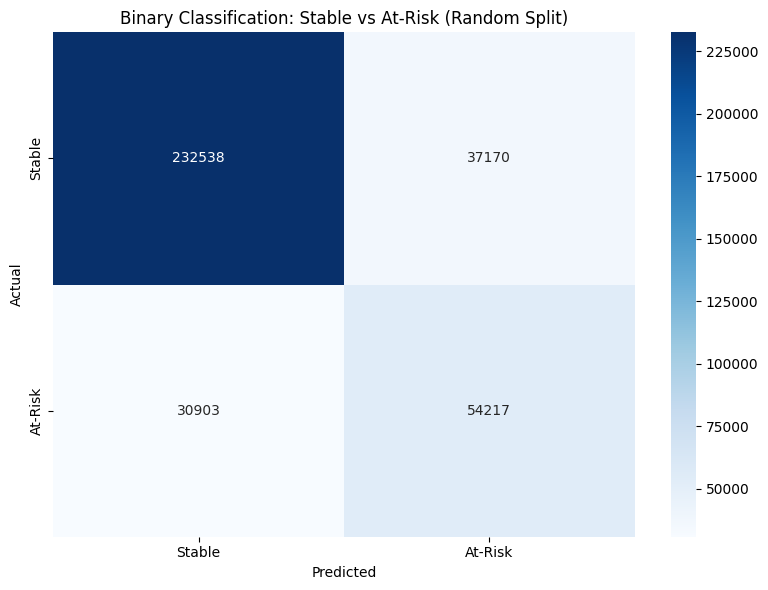

In [14]:
# Strategy 6: Binary classification
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print(f"Binary At-Risk percentage: {y_train_binary.mean()*100:.1f}%")

rus_binary = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_bin_under, y_train_bin_under = rus_binary.fit_resample(X_train, y_train_binary)
print(f"After undersampling: {Counter(y_train_bin_under)}")

model_binary = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss',
    max_depth=6, learning_rate=0.1, n_estimators=500,
    subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=30,
    random_state=42, n_jobs=-1
)
model_binary.fit(
    X_train_bin_under, y_train_bin_under,
    eval_set=[(X_test, y_test_binary)],
    verbose=False
)

y_pred_binary = model_binary.predict(X_test)
binary_names = ['Stable', 'At-Risk']

print(f"\nBest iteration: {model_binary.best_iteration}")
print("\n=== Strategy 6: Binary Classification ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_names))

# Confusion matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Binary Classification: Stable vs At-Risk (Random Split)')
plt.tight_layout()
plt.show()

## 6. Strategy Comparison

=== Strategy Comparison (Random 80/20 Split) ===
                     Strategy  Macro F1  Weighted F1  Balanced Accuracy
    Original (Sample Weights)  0.439112     0.683540           0.522990
             1. Undersampling  0.453113     0.734829           0.473058
                2. Pure SMOTE  0.454521     0.730460           0.478225
       3. Combined Resampling  0.441966     0.693570           0.498101
        4. Aggressive Weights  0.285187     0.404880           0.446120
        5. Threshold Adjusted  0.454731     0.709853           0.501387
6. Binary (Stable vs At-Risk)  0.743326     0.810430           0.749566


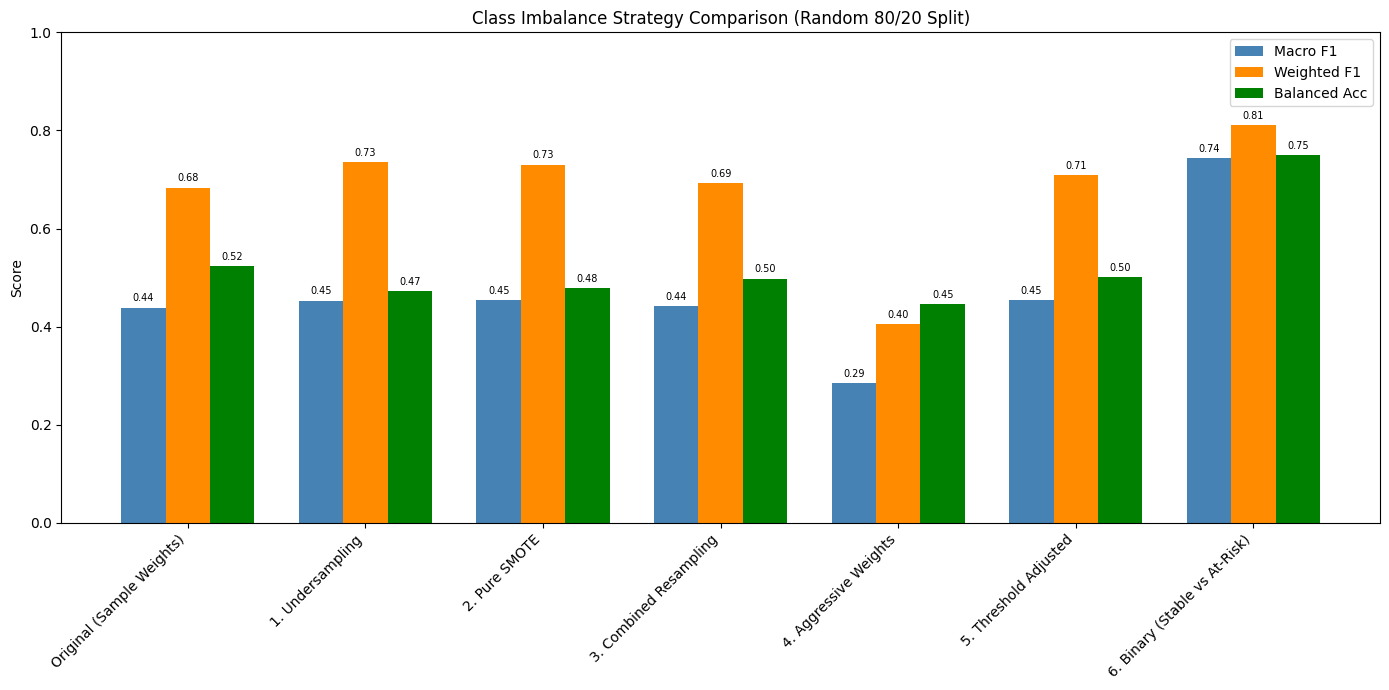

In [15]:
# Compare all 6 strategies
results = [
    {
        'Strategy': 'Original (Sample Weights)',
        'Macro F1': f1_score(y_test, y_pred, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
    },
    {
        'Strategy': '1. Undersampling',
        'Macro F1': f1_score(y_test, y_pred_under, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred_under, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_under)
    },
    {
        'Strategy': '2. Pure SMOTE',
        'Macro F1': f1_score(y_test, y_pred_smote_pure, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred_smote_pure, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote_pure)
    },
    {
        'Strategy': '3. Combined Resampling',
        'Macro F1': f1_score(y_test, y_pred_smote, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred_smote, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote)
    },
    {
        'Strategy': '4. Aggressive Weights',
        'Macro F1': f1_score(y_test, y_pred_aggressive, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred_aggressive, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_aggressive)
    },
    {
        'Strategy': '5. Threshold Adjusted',
        'Macro F1': f1_score(y_test, y_pred_adjusted, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred_adjusted, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_adjusted)
    },
    {
        'Strategy': '6. Binary (Stable vs At-Risk)',
        'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
        'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
        'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
    }
]

comparison_df = pd.DataFrame(results)
print("=== Strategy Comparison (Random 80/20 Split) ===")
print(comparison_df.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, comparison_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, comparison_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('Class Imbalance Strategy Comparison (Random 80/20 Split)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('preprocessing_data/strategy_comparison_random_split.png', dpi=150)
plt.show()

## 7. Feature Importance

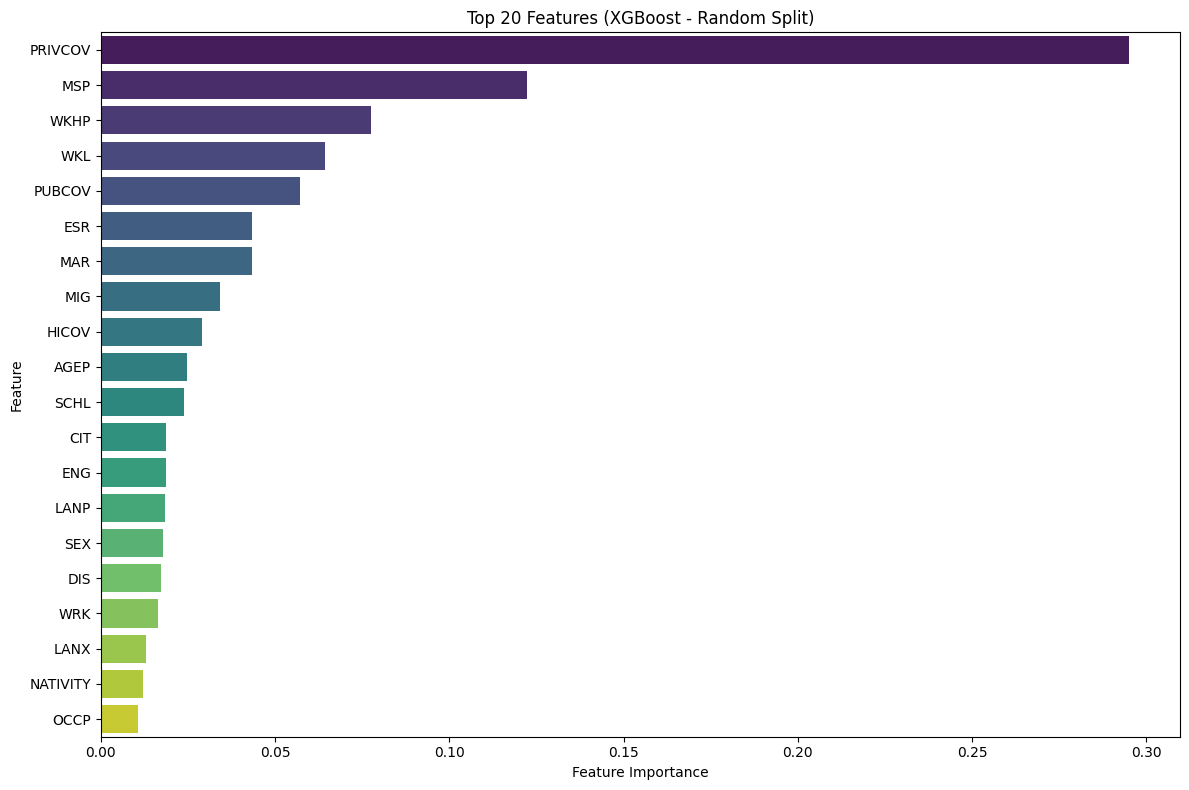


Top 15 Features:
feature  importance
PRIVCOV    0.294900
    MSP    0.122151
   WKHP    0.077531
    WKL    0.064419
 PUBCOV    0.057221
    ESR    0.043456
    MAR    0.043334
    MIG    0.034315
  HICOV    0.028899
   AGEP    0.024718
   SCHL    0.023792
    CIT    0.018762
    ENG    0.018564
   LANP    0.018497
    SEX    0.017762


In [16]:
# Feature importance from baseline model
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features (XGBoost - Random Split)')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_random_split_feature_importance.png', dpi=150)
plt.show()

print("\nTop 15 Features:")
print(importance_df.head(15).to_string(index=False))

## 8. Conclusions & Insights (Random 80/20 Split)

### Strategy Performance Summary

| Strategy | Macro F1 | Weighted F1 | Balanced Acc | Best For |
|----------|----------|-------------|--------------|----------|
| Baseline (Sample Weights) | 0.44 | 0.68 | 0.52 | Default starting point |
| 1. Undersampling | 0.45 | 0.73 | 0.47 | Highest weighted F1 (multi-class) |
| 2. Pure SMOTE | 0.45 | 0.73 | 0.48 | Tied best macro F1 (multi-class) |
| 3. Combined Resampling | 0.44 | 0.69 | 0.50 | Balanced precision/recall |
| 4. Aggressive Weights | 0.29 | 0.40 | 0.45 | Highest minority recall, but too aggressive |
| 5. Threshold Adjusted | 0.45 | 0.71 | 0.50 | Tied best macro F1 (multi-class) |
| **6. Binary (Stable vs At-Risk)** | **0.74** | **0.81** | **0.75** | **Best overall performer** |

### Temporal vs Random Split Comparison

| Metric | Temporal Split (2024 test) | Random Split (80/20) | Difference |
|--------|--------------------------|---------------------|------------|
| Baseline Macro F1 | 0.42 | 0.44 | +0.02 |
| Best Multi-class Macro F1 | 0.45 (Pure SMOTE) | 0.45 (Pure SMOTE / Threshold) | ~0 |
| Best Multi-class Weighted F1 | 0.73 (Undersampling) | 0.73 (Undersampling) | ~0 |
| Binary Macro F1 | 0.74 | 0.74 | ~0 |
| Binary Accuracy | 80% | 81% | +1% |

### Key Findings

1. **Random split performs nearly identically to temporal split** — The differences are negligible across all strategies and metrics. This is strong evidence that there is **no meaningful distribution shift** between survey years 2018-2024. The poverty patterns captured by these ACS features remain stable over time.

2. **Binary classification remains the clear winner** — Regardless of split method, collapsing to Stable vs At-Risk yields 0.74 macro F1 and 81% accuracy, far outperforming any multi-class approach (~0.45 macro F1, ~73% accuracy).

3. **Same strategies win in both splits** — Undersampling and Pure SMOTE are the best multi-class strategies (~0.45 macro F1), while Aggressive Weights fails in both (early stopping at iteration 11, only 34% accuracy). This consistency reinforces that the results are robust and not artifacts of the split method.

4. **Feature importance is consistent** — PRIVCOV (private insurance) dominates at ~0.29, followed by MSP (marital status) at ~0.12 and WKHP (hours worked) at ~0.08. The same features matter regardless of how data is split.

5. **Multi-class poverty separation remains fundamentally difficult** — Even with random split (which removes any temporal confound), the model cannot reliably distinguish Near Poverty vs Poverty vs Deep Poverty. The feature overlap between these classes is inherent to the data, not an artifact of distribution shift.

### What This Means for the Project

- **The temporal split is valid** — Since random and temporal splits produce equivalent results, we can confidently use the temporal split for final evaluation. It better reflects real-world deployment (predicting future poverty risk from past data).
- **Binary classification is the recommended approach** — For policy/intervention use cases, identifying who is "At-Risk" (any poverty level) is both more accurate and more actionable.
- **The ~0.45 macro F1 ceiling for multi-class is a data limitation**, not a modeling one — different models (XGBoost, CatBoost, etc.) and resampling strategies all converge to similar performance, suggesting the 25 ACS features cannot fully separate the 4 poverty severity levels.

In [17]:
# Save models
model.save_model('preprocessing_data/xgboost_random_split_baseline.json')
model_binary.save_model('preprocessing_data/xgboost_random_split_binary.json')

print("Models saved:")
print("  - preprocessing_data/xgboost_random_split_baseline.json")
print("  - preprocessing_data/xgboost_random_split_binary.json")

Models saved:
  - preprocessing_data/xgboost_random_split_baseline.json
  - preprocessing_data/xgboost_random_split_binary.json
